C:\Users\manur\AppData\Local\Temp\ipykernel_1500\2314715129.py:144: RuntimeWarning:

Mean of empty slice

C:\Users\manur\AppData\Local\Temp\ipykernel_1500\2314715129.py:144: RuntimeWarning:

Mean of empty slice

C:\Users\manur\AppData\Local\Temp\ipykernel_1500\2314715129.py:144: RuntimeWarning:

Mean of empty slice

C:\Users\manur\AppData\Local\Temp\ipykernel_1500\2314715129.py:144: RuntimeWarning:

Mean of empty slice

C:\Users\manur\AppData\Local\Temp\ipykernel_1500\2314715129.py:144: RuntimeWarning:

Mean of empty slice

C:\Users\manur\AppData\Local\Temp\ipykernel_1500\2314715129.py:144: RuntimeWarning:

Mean of empty slice

C:\Users\manur\AppData\Local\Temp\ipykernel_1500\2314715129.py:144: RuntimeWarning:

Mean of empty slice

C:\Users\manur\AppData\Local\Temp\ipykernel_1500\2314715129.py:144: RuntimeWarning:

Mean of empty slice

C:\Users\manur\AppData\Local\Temp\ipykernel_1500\2314715129.py:144: RuntimeWarning:

Mean of empty slice

C:\Users\manur\AppData\Local\Temp\ipykernel_15


Centroid distance matrix (UMAP space):
Burst_Type   Non-burst     Other  Parabolic  Square Wave
Burst_Type                                              
Non-burst     0.000000  6.298329   6.489494     9.508167
Other         6.298329  0.000000   4.686298     3.212923
Parabolic     6.489494  4.686298   0.000000     6.379337
Square Wave   9.508167  3.212923   6.379337     0.000000

Centroid proximity threshold (10th percentile): 3.3603

Potentially overlapping centroid pairs: [('Other', 'Square Wave')]

Detected 148 segments in conflict regions (neighborhood mixing).
Burst_Type
Non-burst      13
Other          21
Parabolic      66
Square Wave    48
dtype: int64


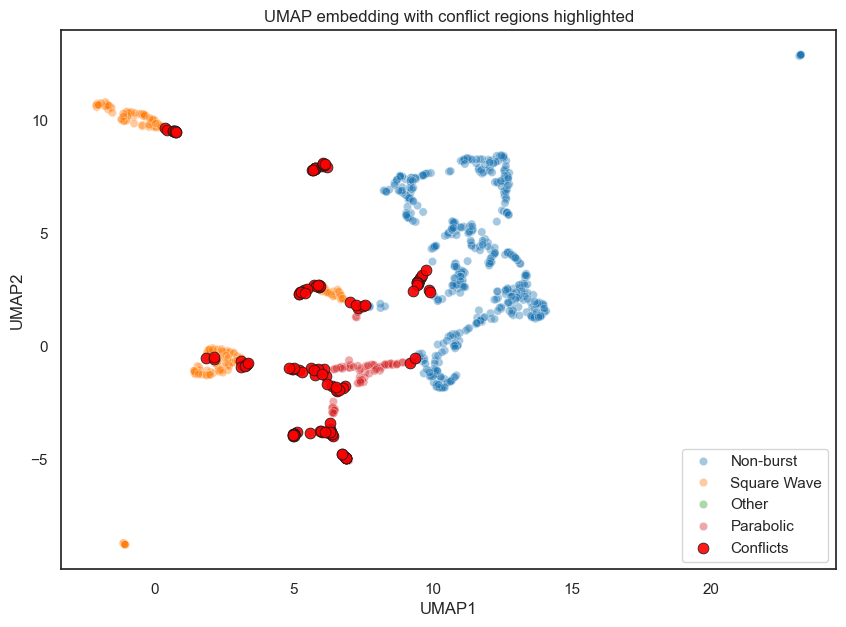

In [1]:


# Imports

import os                       
import pyabf                       
import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis
from scipy.signal import find_peaks, hilbert
from numpy.linalg import lstsq
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
import umap
from scipy.spatial import distance
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white', context='notebook', rc={'figure.figsize':(14,10)})
from dash import Dash, dcc, html, Input, Output
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "browser"


# Parameters 

folder_path = "bursting"
threshold = -35
burst_threshold = 0.3
fs = 10000
dt = 1 / fs
min_spikes_in_burst = 4

# Accumulators
all_segment_metrics = []
all_segment_traces = []

# Collect ABF files
abf_files = [f for f in os.listdir(folder_path) if f.endswith(".abf")]



# ABF processing, spike detection, burst grouping, features

# This is the core signal-processing block:
# - numerical choices,
# - edge-case handling,
# - and where you'd change behavior´

for file_name in abf_files:
    file_path = os.path.join(folder_path, file_name)
    abf = pyabf.ABF(file_path)

    for sweep in range(abf.sweepCount):
        abf.setSweep(sweep)
        time = abf.sweepX
        voltage = abf.sweepY

        # Spike detection (thresholding)

        # find_peaks returns indices of local maxima. Using only "height" is simple
        # and fast, but sensitive to baseline drift and noise. 

        peaks, _ = find_peaks(voltage, height=threshold)
        # Convert sample indices to times. If each file can have a different
        # sampling rate, prefer abf.dataRate rather than global fs.
        spike_times = peaks / fs

        # Burst detection via ISI clustering
        # Algorithm: consecutive spikes separated by ISI < burst_threshold belong to the same burst.
        # Rationale: bursts are rapid spike clusters, the ISI threshold controls temporal scale.
        bursts = []
        if len(spike_times) >= min_spikes_in_burst:
            isi = np.diff(spike_times)            # vector of ISIs in seconds
            current_burst = [spike_times[0]]      # start accumulator with first spike time

            # Walk through spikes and group them into bursts
            # Note: we iterate over spike indices, not raw signal samples, efficient and robust.
            for i in range(1, len(spike_times)):
                if isi[i-1] < burst_threshold:
                    # Small gap, same burst
                    current_burst.append(spike_times[i])
                else:
                    # Gap too big, end current burst
                    if len(current_burst) >= min_spikes_in_burst:
                        bursts.append((current_burst[0], current_burst[-1]))
                    # Start a new candidate burst
                    current_burst = [spike_times[i]]

            # After loop, append the final burst if valid
            if len(current_burst) >= min_spikes_in_burst:
                bursts.append((current_burst[0], current_burst[-1]))
        # Edge cases:
        # - If no spikes, "spike_times" is empty and "bursts" stays empty.
        # - If spikes but none meet "min_spikes_in_burst", "bursts" remains empty.

        # Build chronological segments (bursts + non-bursts)
        # We will create a list of (start, end, type) covering the entire sweep in order.
        segments = []
        for start, end in bursts:
            segments.append((start, end, "Burst"))

        if bursts:
            # If there's a gap before the first burst, add Non-burst
            if bursts[0][0] > time[0]:
                segments.insert(0, (time[0], bursts[0][0], "Non-burst"))
            # Add non-burst sections between bursts
            for i in range(len(bursts)-1):
                segments.append((bursts[i][1], bursts[i+1][0], "Non-burst"))
            # Add final non-burst after last burst if it isn't the end of sweep
            if bursts[-1][1] < time[-1]:
                segments.append((bursts[-1][1], time[-1], "Non-burst"))
        else:
            # Entire sweep is non-burst
            segments.append((time[0], time[-1], "Non-burst"))

        # Classify bursts and compute shape descriptors

        # We'll compute: local baseline (mean before/after), burst_min, parabola-fit R^2,
        # Hilbert envelope symmetry, spike rate. These feed the "Square Wave / Parabolic / Other" labeling.

        burst_types = []
        for i, (seg_start, seg_end, seg_type) in enumerate(segments):
            if seg_type == "Burst":
                # Extract the raw voltage segment for this burst
                seg_mask = (time >= seg_start) & (time <= seg_end)
                seg_voltage = voltage[seg_mask]

                # local baseline estimation
                # Use the mean of the preceding inter-burst segment and the following inter-burst segment (if they exist).
                # This acts as a local baseline to compare the burst trough against.
                prev_mean = np.nan
                next_mean = np.nan
                if i > 0:
                    prev_end = segments[i-1][1]
                    inter_mask_prev = (time > prev_end) & (time < seg_start)
                    if np.any(inter_mask_prev):
                        prev_mean = np.mean(voltage[inter_mask_prev])
                if i < len(segments)-1:
                    next_start = segments[i+1][0]
                    inter_mask_next = (time > seg_end) & (time < next_start)
                    if np.any(inter_mask_next):
                        next_mean = np.mean(voltage[inter_mask_next])
                inter_mean = np.nanmean([prev_mean, next_mean])  # NaN-safe average

                burst_min = np.min(seg_voltage)  # the trough within the burst window

                # parabola fit
                # Fit y = a t^2 + b t + c across the normalized burst time [-0.5, 0.5].
                # The R^2 indicates how "parabolic" the burst is.
                t_fit = np.linspace(-0.5, 0.5, len(seg_voltage))
                X = np.vstack([t_fit**2, t_fit, np.ones_like(t_fit)]).T
                coef, *_ = lstsq(X, seg_voltage, rcond=None)
                y_hat = X @ coef
                r2_parabola = r2_score(seg_voltage, y_hat)

                # symmetry: Hilbert envelope 
                # The envelope (abs(Hilbert)) summarizes instantaneous amplitude,
                # comparing the first half to the reversed second half gives a crude symmetry metric.
                analytic_signal = hilbert(seg_voltage)
                envelope = np.abs(analytic_signal)
                half = len(envelope)//2
                symmetry = (np.corrcoef(envelope[:half], envelope[-half:][::-1])[0,1] if half >= 2 else np.nan)

                # spike rate inside burst 
                seg_peaks, _ = find_peaks(seg_voltage, height=threshold)
                spike_rate = len(seg_peaks) / (seg_end - seg_start) if (seg_end - seg_start) > 0 else np.nan

                # labeling heuristic
                # If no surrounding baseline (inter_mean is NaN), cannot compare, label "Other".
                # Else, if burst_min > baseline, it stays above baseline, "Square Wave".
                # If burst_min < baseline, "Parabolic".
                if np.isnan(inter_mean):
                    burst_type = "Other"
                elif burst_min > inter_mean:
                    burst_type = "Square Wave"
                elif burst_min < inter_mean:
                    burst_type = "Parabolic"
                else:
                    burst_type = "Other"
            else:
                # Non-burst segments get explicit label
                burst_type = "Non-burst"

            burst_types.append(burst_type)

        # Per-segment metric extraction

        # For each segment (burst or non-burst) compute a vector of features.
        # These features will be used later for UMAP and conflict detection.
        for j, (seg_start, seg_end, seg_type) in enumerate(segments):
            seg_mask = (time >= seg_start) & (time <= seg_end)
            seg_voltage = voltage[seg_mask]
            duration = seg_end - seg_start
            burst_type = burst_types[j]

            # spike-derived features inside the segment
            seg_peaks, _ = find_peaks(seg_voltage, height=threshold)
            num_peaks = len(seg_peaks)
            mean_isi = np.mean(np.diff(seg_peaks / fs)) if num_peaks >= 2 else 0

            # robustly handle very short segments (avoid divide-by-zero or empty arrays)
            if len(seg_voltage) < 2:
                mean_val = std_val = min_val = max_val = skew_val = kurt_val = area_val = 0
                mean_d = std_d = min_d = max_d = skew_d = kurt_d = 0
            else:
                mean_val = np.mean(seg_voltage)
                std_val = np.std(seg_voltage)
                min_val = np.min(seg_voltage)
                max_val = np.max(seg_voltage)
                skew_val = skew(seg_voltage)
                kurt_val = kurtosis(seg_voltage)
                # Area (integral), uses constant sampling interval dt, if sampling varies use np.trapz(seg_voltage, seg_time)
                area_val = np.trapezoid(seg_voltage, dx=dt)

                # derivative-based features capture dynamics of rising/falling slopes
                deriv = np.diff(seg_voltage) / dt
                mean_d = np.mean(deriv)
                std_d = np.std(deriv)
                min_d = np.min(deriv)
                max_d = np.max(deriv)
                skew_d = skew(deriv)
                kurt_d = kurtosis(deriv)

            # Save both numeric metrics and the trace itself for interactive inspection
            all_segment_metrics.append([
                file_name, sweep, seg_type, burst_type, duration,
                num_peaks, mean_isi,
                mean_val, std_val, min_val, max_val, skew_val, kurt_val, area_val,
                mean_d, std_d, min_d, max_d, skew_d, kurt_d
            ])
            # Save trace as a Python list (useful for JSON / np.save later). Keep modest memory footprint in mind.
            all_segment_traces.append(seg_voltage.tolist())



# UMAP embedding + conflict detection

# Here we build a feature matrix from the computed metrics, normalize it,
# run UMAP to obtain a 2D embedding, then detect points that sit in "mixed"
# neighborhoods using nearest neighbors. This reveals ambiguities between classes.

# Build DataFrame
df_segments = pd.DataFrame(all_segment_metrics, columns=[
    "File_Name", "Sweep", "Segment_Type", "Burst_Type", "Duration",
    "Num_Peaks", "Mean_ISI",
    "Mean", "Std", "Min", "Max", "Skewness", "Kurtosis", "Area",
    "Mean_Deriv", "Std_Deriv", "Min_Deriv", "Max_Deriv", "Skewness_Deriv", "Kurtosis_Deriv"
])

# Features used for UMAP (numeric columns only)
header = list(df_segments)[4:]  # starting from "Duration", excludes file/sweep metadata
X = np.array(df_segments[header])
y = np.array(df_segments.Burst_Type)

# Standardize features so each has zero mean and unit variance. Important for UMAP distance calculations.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Run UMAP (2D)
reducer = umap.UMAP(n_components=2, random_state=42)
embedding = reducer.fit_transform(X_scaled)
df_segments["UMAP1"] = embedding[:, 0]
df_segments["UMAP2"] = embedding[:, 1]

# Save embedding and traces for reproducibility
df_segments.to_csv("segment_voltage_metrics_with_ISI_and_peaks.csv", index=False)
np.save("segment_traces.npy", np.array(all_segment_traces, dtype=object))

# Conflict detection: centroid proximity (coarse) + k-NN neighborhood (fine)

# 1) Compute centroids for each burst type, gives coarse measure of class separation
df_umap = pd.DataFrame(embedding, columns=["UMAP1", "UMAP2"])
df_umap["Burst_Type"] = y
df_umap["Index"] = df_segments.index  # mapping back to full df rows

centroids = df_umap.groupby("Burst_Type")[["UMAP1", "UMAP2"]].mean()
dist_matrix = distance.cdist(centroids.values, centroids.values)
# Choose a heuristic threshold: 10th percentile of non-zero centroid distances
threshold_centroid = np.percentile(dist_matrix[dist_matrix > 0], 10)

# Print centroid distances to inspect separability
dist_df = pd.DataFrame(dist_matrix, index=centroids.index, columns=centroids.index)
print("\nCentroid distance matrix (UMAP space):")
print(dist_df)
print(f"\nCentroid proximity threshold (10th percentile): {threshold_centroid:.4f}")

close_pairs = []
for i, type_i in enumerate(centroids.index):
    for j, type_j in enumerate(centroids.index):
        if j > i and dist_matrix[i, j] < threshold_centroid:
            close_pairs.append((type_i, type_j))
print("\nPotentially overlapping centroid pairs:", close_pairs)

# 2) Fine detection: k-NN neighborhoods for each point to find local mixing
# Build k-NN model in the 2D UMAP space, k controls locality (8 may be a good starting point)
X_umap = df_umap[["UMAP1", "UMAP2"]].values
labels = df_umap["Burst_Type"].values
nbrs = NearestNeighbors(n_neighbors=8).fit(X_umap)
distances_knn, indices_knn = nbrs.kneighbors(X_umap)

# For each point, check if any of its neighbors belong to a different class
conflict_indices = []
for i, neighbors in enumerate(indices_knn):
    my_label = labels[i]
    neighbor_labels = labels[neighbors]
    if np.any(neighbor_labels != my_label):
        # Add the original df index (so we can index df_segments later)
        conflict_indices.append(df_umap.iloc[i]["Index"])

# Deduplicate indices (a same row may appear multiple times theoretically)
conflict_indices = list(dict.fromkeys(conflict_indices))

conflicts_df = df_segments.iloc[conflict_indices]
print(f"\nDetected {len(conflicts_df)} segments in conflict regions (neighborhood mixing).")
print(conflicts_df.groupby("Burst_Type").size())

# Visualization: show UMAP scatter and highlight conflicts
plt.figure(figsize=(10, 7))
sns.scatterplot(data=df_umap, x="UMAP1", y="UMAP2", hue="Burst_Type", alpha=0.4, palette="tab10")
# scatter conflict points on top
conflict_mask = df_umap["Index"].isin(conflict_indices)
sns.scatterplot(data=df_umap[conflict_mask], x="UMAP1", y="UMAP2",
                color="red", s=60, label="Conflicts", alpha=0.9, edgecolor="k")
plt.title("UMAP embedding with conflict regions highlighted")
plt.show()


# DEEP: Interactive dashboard (Dash), how UI connects to data

# This dashboard lets you click a UMAP point and view the raw trace for that segment.
# Important pieces:
#  - dcc.Graph uses Plotly figure with "custom_data s"o the callback can retrieve an ID.
#  - callback takes clickData and returns a Plotly figure with the corresponding trace.
#  - all_segment_traces stores per-segment voltage arrays in the same order as df_segments.

app = Dash(__name__)
app.layout = html.Div([
    html.H2("UMAP + Burst Explorer"),
    html.P("Click a point in the UMAP plot to show the corresponding voltage trace below."),
    dcc.Graph(
        id="umap",
        figure=px.scatter(
            df_umap,
            x="UMAP1",
            y="UMAP2",
            color="Burst_Type",
            hover_data=["Index", "Burst_Type"],
            custom_data=["Index"],
            title="UMAP embedding of segments"
        )
    ),
    dcc.Graph(id="timeseries")
])

# Callback: when a point is clicked, display the stored trace
@app.callback(
    Output("timeseries", "figure"),
    Input("umap", "clickData")
)
def display_timeseries(clickData):
    # If user hasn't clicked, return a placeholder figure
    if clickData is None:
        fig = go.Figure()
        fig.update_layout(title="Click a point in the UMAP plot to view the segment trace")
        return fig

    # Extract the selected segment's index (custom_data carries the df index)
    burst_index = clickData["points"][0]["customdata"][0]
    # Fetch stored trace (ensure index is int and within bounds)
    trace = np.array(all_segment_traces[int(burst_index)])
    t = np.linspace(0, len(trace) / fs, len(trace))  # time axis for this segment

    # Build Plotly figure for interactive exploration (zoom, hover)
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=t, y=trace, mode="lines", name=f"Segment {burst_index}"))
    fig.update_layout(
        title=f"Segment {burst_index} — File: {df_segments.loc[burst_index,'File_Name']} | Sweep: {df_segments.loc[burst_index,'Sweep']} | Type: {df_segments.loc[burst_index,'Burst_Type']}",
        xaxis_title="Time (s)",
        yaxis_title="Voltage (mV)"
    )
    return fig

# Run the app, in notebooks you may prefer app.run_server(mode='inline') or similar.
if __name__ == "__main__":
    app.run(debug=True)


In [ ]:
# Libraries


import os                          
import pyabf                      
import numpy as np                 
import pandas as pd                
from scipy.stats import skew, kurtosis   
from scipy.signal import find_peaks, hilbert  
from numpy.linalg import lstsq    
from sklearn.metrics import r2_score   
from sklearn.preprocessing import StandardScaler  
import umap                        
from scipy.spatial import distance             
from sklearn.neighbors import NearestNeighbors 
from fastdtw import fastdtw        
from scipy.stats import pearsonr    
from joblib import Parallel, delayed 
import matplotlib.pyplot as plt     
import seaborn as sns               
sns.set(style='white', context='notebook', rc={'figure.figsize': (14, 10)})
from dash import Dash, dcc, html, Input, Output
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "browser"  # Open Plotly figures in the system browser by default


# 1. Parameters
folder_path = "bursting"  
threshold = -35            
burst_threshold = 0.3     
fs = 10000                
dt = 1 / fs                
min_spikes_in_burst = 4    
n_jobs = 4                 

# Data stores
all_segment_metrics = []   # will hold per-segment numeric features
all_segment_traces = []    # will store voltage arrays (as lists) for each segment

# Find all .abf files in the folder (top-level only)
abf_files = [f for f in os.listdir(folder_path) if f.endswith(".abf")]



# 2. ABF Processing Loop

# For each ABF file and each sweep, detect spikes, detect bursts (groups of spikes),
# segment the trace into "Burst" and "Non-burst", compute metrics, and store traces.

for file_name in abf_files:
    # Build the full file path (portable across OSs)
    file_path = os.path.join(folder_path, file_name)

    # Load ABF file. pyabf reads headers, sweep count, sampling rate, and sweep data.
    abf = pyabf.ABF(file_path)

    # Iterate through each sweep (trial) inside this ABF file
    for sweep in range(abf.sweepCount):
        abf.setSweep(sweep)         # configure pyabf to return sweep-specific arrays
        time = abf.sweepX           # time vector (seconds) for current sweep
        voltage = abf.sweepY        # voltage vector (mV) for current sweep

        # Spike detection 
        # Use a simple amplitude-based peak detection. This finds indices of local maxima with height >= threshold.
        # Note: this expects spikes to be positive-going peaks above "threshold". If spikes are negative, invert signal.
        peaks, _ = find_peaks(voltage, height=threshold)
        # Convert peak indices to times in seconds. If ABF files can have different data rates, use abf.dataRate here.
        spike_times = peaks / fs

        # Burst detection via ISI 
        # Group spikes into bursts when consecutive ISIs < burst_threshold.
        bursts = []  # list of (burst_start_time, burst_end_time)
        if len(spike_times) >= min_spikes_in_burst:
            isi = np.diff(spike_times)       # inter-spike intervals (seconds)
            current_burst = [spike_times[0]] # accumulator for current burst

            # Walk spike_times and group adjacent spikes when ISI is small
            for i in range(1, len(spike_times)):
                if isi[i - 1] < burst_threshold:
                    # short gap, same burst
                    current_burst.append(spike_times[i])
                else:
                    # long gap, end of current burst
                    if len(current_burst) >= min_spikes_in_burst:
                        bursts.append((current_burst[0], current_burst[-1]))
                    # start a new candidate burst
                    current_burst = [spike_times[i]]

            # After loop, save the last burst if it meets minimum length
            if len(current_burst) >= min_spikes_in_burst:
                bursts.append((current_burst[0], current_burst[-1]))

        # Build chronological segments (Burst / Non-burst)
        segments = []
        # Add "Burst" segments directly
        for start, end in bursts:
            segments.append((start, end, "Burst"))

        # If bursts found, add Non-burst segments before/between/after bursts to cover whole sweep
        if bursts:
            # Pre-first-burst non-burst area
            if bursts[0][0] > time[0]:
                segments.insert(0, (time[0], bursts[0][0], "Non-burst"))
            # Between bursts
            for i in range(len(bursts) - 1):
                segments.append((bursts[i][1], bursts[i + 1][0], "Non-burst"))
            # After last burst
            if bursts[-1][1] < time[-1]:
                segments.append((bursts[-1][1], time[-1], "Non-burst"))
        else:
            # No bursts at all, entire sweep is Non-burst
            segments.append((time[0], time[-1], "Non-burst"))

        # Burst classification and shape descriptors 
        # For each "Burst" segment, compute: local baseline (pre/post), parabola fit R^2, Hilbert-envelope symmetry,
        # spike rate, and decide whether it is Square Wave, Parabolic, or Other.
        burst_types = []
        for i, (seg_start, seg_end, seg_type) in enumerate(segments):
            if seg_type == "Burst":
                # Mask and extract the voltage samples that belong to this segment
                seg_mask = (time >= seg_start) & (time <= seg_end)
                seg_voltage = voltage[seg_mask]

                # Compute baseline as mean of the immediate pre- and post- inter-burst regions (if present)
                prev_mean = np.nan
                next_mean = np.nan
                if i > 0:
                    prev_end = segments[i - 1][1]
                    inter_mask_prev = (time > prev_end) & (time < seg_start)
                    if np.any(inter_mask_prev):
                        prev_mean = np.mean(voltage[inter_mask_prev])
                if i < len(segments) - 1:
                    next_start = segments[i + 1][0]
                    inter_mask_next = (time > seg_end) & (time < next_start)
                    if np.any(inter_mask_next):
                        next_mean = np.mean(voltage[inter_mask_next])
                # nanmean handles cases where prev_mean or next_mean may be nan (edge bursts)
                inter_mean = np.nanmean([prev_mean, next_mean])

                # Basic shape features
                burst_min = np.min(seg_voltage)  # trough/minimum inside the burst window

                # Parabola fit: model the burst waveform as y = a t^2 + b t + c over normalized t in [-0.5, 0.5]
                # coef are least-squares coefficients, y_hat are predictions, r2_parabola tells goodness-of-fit to a parabola
                t_fit = np.linspace(-0.5, 0.5, len(seg_voltage))
                X = np.vstack([t_fit**2, t_fit, np.ones_like(t_fit)]).T
                coef, *_ = lstsq(X, seg_voltage, rcond=None)
                y_hat = X @ coef
                r2_parabola = r2_score(seg_voltage, y_hat)  # near 1, very parabolic

                # Hilbert transform: analytic signal and envelope, symmetry compares first half to reversed second half
                analytic_signal = hilbert(seg_voltage)
                envelope = np.abs(analytic_signal)
                half = len(envelope) // 2
                symmetry = (np.corrcoef(envelope[:half], envelope[-half:][::-1])[0, 1]
                            if half >= 2 else np.nan)

                # Spike metrics in the burst window
                seg_peaks, _ = find_peaks(seg_voltage, height=threshold)
                spike_rate = len(seg_peaks) / (seg_end - seg_start) if (seg_end - seg_start) > 0 else np.nan

                # Classify burst based on relative min vs baseline:
                # - if no baseline (inter_mean is NaN), label 'Other'
                # - if burst_min > inter_mean => stays above baseline, 'Square Wave'
                # - if burst_min < inter_mean => dips below baseline, 'Parabolic'
                if np.isnan(inter_mean):
                    burst_type = "Other"
                elif burst_min > inter_mean:
                    burst_type = "Square Wave"
                elif burst_min < inter_mean:
                    burst_type = "Parabolic"
                else:
                    burst_type = "Other"
            else:
                # For Non-burst segments we simply label as such
                burst_type = "Non-burst"

            burst_types.append(burst_type)

        # Compute per-segment metrics (final feature vector) 
        # For each segment, compute descriptive statistics and derivative statistics.
        for j, (seg_start, seg_end, seg_type) in enumerate(segments):
            seg_mask = (time >= seg_start) & (time <= seg_end)
            seg_voltage = voltage[seg_mask]

            duration = seg_end - seg_start
            burst_type = burst_types[j]

            # Re-detect peaks in the segment (local peaks relative to the segment signal)
            seg_peaks, _ = find_peaks(seg_voltage, height=threshold)
            num_peaks = len(seg_peaks)
            mean_isi = np.mean(np.diff(seg_peaks / fs)) if num_peaks >= 2 else 0

            # Basic distributional stats (guard on very short segments)
            if len(seg_voltage) < 2:
                mean_val = std_val = min_val = max_val = skew_val = kurt_val = area_val = 0
            else:
                mean_val = np.mean(seg_voltage)
                std_val = np.std(seg_voltage)
                min_val = np.min(seg_voltage)
                max_val = np.max(seg_voltage)
                skew_val = skew(seg_voltage)
                kurt_val = kurtosis(seg_voltage)
                # Area under curve approximated with trapezoid, dx uses constant dt
                area_val = np.trapezoid(seg_voltage, dx=dt)

            # Derivative stats (first diff approximates dV/dt)
            if len(seg_voltage) < 2:
                mean_d = std_d = min_d = max_d = skew_d = kurt_d = 0
            else:
                deriv = np.diff(seg_voltage) / dt
                mean_d = np.mean(deriv)
                std_d = np.std(deriv)
                min_d = np.min(deriv)
                max_d = np.max(deriv)
                skew_d = skew(deriv)
                kurt_d = kurtosis(deriv)

            # Append metric row and keep the raw trace
            all_segment_metrics.append([
                file_name, sweep, seg_type, burst_type, duration,
                num_peaks, mean_isi,
                mean_val, std_val, min_val, max_val, skew_val, kurt_val, area_val,
                mean_d, std_d, min_d, max_d, skew_d, kurt_d
            ])
            # Save the raw segment voltage as a Python list (convenient for JSON/np.save)
            all_segment_traces.append(seg_voltage.tolist())



# 3. Save CSV and traces

# Convert accumulated metrics into a DataFrame and export to CSV for reproducibility.
df_segments = pd.DataFrame(all_segment_metrics, columns=[
    "File_Name", "Sweep", "Segment_Type", "Burst_Type", "Duration",
    "Num_Peaks", "Mean_ISI",
    "Mean", "Std", "Min", "Max", "Skewness", "Kurtosis", "Area",
    "Mean_Deriv", "Std_Deriv", "Min_Deriv", "Max_Deriv", "Skewness_Deriv", "Kurt_Deriv"
])
df_segments.to_csv("segment_voltage_metrics_with_ISI_and_peaks.csv", index=False)

# Attach the raw signal arrays to the DataFrame for convenience in interactive viewing.
# Note: Storing large lists inside DataFrame may increase memory, for big datasets consider storing file+start+end instead.
df_segments["signal_array"] = all_segment_traces



# 4. UMAP dimensionality reduction

# Select the numeric feature columns (exclude metadata and raw traces).
header = list(df_segments)[4:-1]  # numeric features start at index 4, exclude the final "signal_array" column
X = np.array(df_segments[header])
y = np.array(df_segments.Burst_Type)

# Standardize features: zero mean and unit variance improves many distance-based methods (including UMAP)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Run UMAP with 2 components (embedding into 2D). random_state ensures reproducibility.
reducer = umap.UMAP(n_components=2, random_state=42)
embedding = reducer.fit_transform(X_scaled)

# Create a DataFrame with embedding coordinates and labels for plotting and analysis
df_umap = pd.DataFrame(embedding, columns=["UMAP1", "UMAP2"])
df_umap["Burst_Type"] = y
df_umap["id"] = np.arange(len(df_umap))
df_umap["Index"] = df_segments.index  # keep original index mapping



# 5. Detect conflicts between burst types in UMAP

# Two complementary strategies:
# - centroid distance: coarse test of class separation
# - local neighborhood mixing via k-NN: fine-grained detection of ambiguous points

# Centroids per class in UMAP (center of each labeled group)
centroids = df_umap.groupby("Burst_Type")[["UMAP1", "UMAP2"]].mean()
dist_matrix = distance.cdist(centroids.values, centroids.values)
# Heuristic threshold: 10th percentile of non-zero centroid distances, "too close" centroids
threshold_overlap = np.percentile(dist_matrix[dist_matrix > 0], 10)

# k-NN in UMAP space: find neighbor labels for each point
X_umap = df_umap[["UMAP1", "UMAP2"]].values
labels = df_umap["Burst_Type"].values
nbrs = NearestNeighbors(n_neighbors=8).fit(X_umap)
distances, indices = nbrs.kneighbors(X_umap)

# A point is marked "conflict" if at least one of its neighbors has a different label.
conflict_indices = []
for i, neighbors in enumerate(indices):
    own_type = labels[i]
    neighbor_types = labels[neighbors]
    if np.any(neighbor_types != own_type):
        # Append the original df index to map back to df_segments
        conflict_indices.append(df_umap.iloc[i]["Index"])

# Extract those conflicting segments (indices may contain duplicates, reset index for convenience)
df_conflict = df_segments.iloc[conflict_indices].reset_index(drop=True)
# Add their UMAP coordinates for plotting/analysis
df_conflict["UMAP1"] = df_umap.iloc[conflict_indices]["UMAP1"].values
df_conflict["UMAP2"] = df_umap.iloc[conflict_indices]["UMAP2"].values



# 6. Shape analysis using DTW and correlation

# For each conflicting segment, compare its waveform to nearby conflicting segments using DTW alignment
# followed by Pearson correlation on the aligned signals, produces robust similarity metrics.

def normalize(x):
    # Z-score normalize a 1D signal, add small epsilon to avoid divide-by-zero.
    x = np.array(x)
    return (x - np.mean(x)) / (np.std(x) + 1e-8)

def dtw_correlation(sig1, sig2):
    
    # Align two signals with FastDTW and compute Pearson correlation of aligned traces.
    # Returns (dtw_distance, correlation_coefficient).
    # - dtw_distance: lower means more similar in time-warped sense.
    # - correlation_coefficient: -1..1 measure after alignment (1 means perfectly correlated).
    
    s1, s2 = normalize(sig1), normalize(sig2)
    dist, path = fastdtw(s1, s2)  # returns total distance and alignment path
    # Build aligned arrays using the warping path
    aligned1 = np.array([s1[i] for i, j in path])
    aligned2 = np.array([s2[j] for i, j in path])
    corr = pearsonr(aligned1, aligned2)[0]  # Pearson r
    return dist, corr

# Build neighbor graph among conflict points in UMAP space
embedding_conflict = df_conflict[["UMAP1", "UMAP2"]].values
nbrs_conflict = NearestNeighbors(n_neighbors=6).fit(embedding_conflict)
_, indices_conflict = nbrs_conflict.kneighbors(embedding_conflict)

def compute_similarity(i):
    # For conflict point i, compute mean DTW distance and mean correlation to its neighborhood.
    
    sig_i = df_conflict.iloc[i]["signal_array"]
    if not isinstance(sig_i, (list, np.ndarray)):
        return np.nan, np.nan
    local_dtw, local_corr = [], []
    # skip the first neighbor if it's the point itself (indices_conflict includes self at position 0)
    for j in indices_conflict[i, 1:]:
        sig_j = df_conflict.iloc[j]["signal_array"]
        if not isinstance(sig_j, (list, np.ndarray)):
            continue
        dist, corr = dtw_correlation(sig_i, sig_j)
        local_dtw.append(dist)
        local_corr.append(corr)
    return np.nanmean(local_dtw), np.nanmean(local_corr)

# Parallelize the similarity computations across CPU cores to speed up DTW-heavy work
results = Parallel(n_jobs=n_jobs)(delayed(compute_similarity)(i) for i in range(len(df_conflict)))
dtw_dists, corr_means = zip(*results) if len(results) > 0 else ([], [])

# Append results to conflict DataFrame
df_conflict["Mean_DTW_Dist"] = dtw_dists
df_conflict["Mean_Corr_PostDTW"] = corr_means

# Combine DTW (distance) and correlation into a Shape_Similarity_Index in range roughly [0,1].
# We invert DTW distance (smaller, more similar) and normalize both components to max observed values.
# Then give them equal weight (0.5 each). This is heuristic, tune weights for your use-case.
if len(df_conflict) > 0:
    max_dtw = np.nanmax(df_conflict["Mean_DTW_Dist"])
    max_corr = np.nanmax(df_conflict["Mean_Corr_PostDTW"])
    # Avoid division by zero if max is 0 or nan
    if max_dtw == 0 or np.isnan(max_dtw):
        max_dtw = 1.0
    if max_corr == 0 or np.isnan(max_corr):
        max_corr = 1.0

    df_conflict["Shape_Similarity_Index"] = (
        (1 - df_conflict["Mean_DTW_Dist"] / max_dtw) * 0.5 +
        (df_conflict["Mean_Corr_PostDTW"] / max_corr) * 0.5
    )
else:
    df_conflict["Shape_Similarity_Index"] = []

# Visualize shape coherence (color by similarity index)
if len(df_conflict) > 0:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(
        data=df_conflict,
        x="UMAP1", y="UMAP2",
        hue="Shape_Similarity_Index",
        palette="viridis", s=50
    )
    plt.title("Shape coherence in conflicting regions")
    plt.legend(title="Similarity", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

    # Identify low-similarity bursts (bottom 10% quantile)
    threshold_low = df_conflict["Shape_Similarity_Index"].quantile(0.1)
    low_similarity_bursts = df_conflict[df_conflict["Shape_Similarity_Index"] < threshold_low]
    print(f"Low-similarity conflicting bursts (<p10): {len(low_similarity_bursts)}")

    # Plot a few examples (normalized) to visually inspect anomalous shapes
    for idx in low_similarity_bursts.index[:5]:
        sig = df_conflict.loc[idx, "signal_array"]
        plt.figure()
        plt.plot(normalize(sig))
        plt.title(f"Burst #{idx} - Shape Similarity Index = {df_conflict.loc[idx,'Shape_Similarity_Index']:.3f}")
        plt.xlabel("Normalized time")
        plt.ylabel("Normalized amplitude")
        plt.show()


# 7. Interactive Dashboard

# A small web UI to click UMAP points and display the corresponding raw trace.
# The critical connection is the `custom_data` we attach to the scatter plot, which we use in the callback.

# Create Dash app
app = Dash(__name__)

# UMAP scatter + timeseries viewer
app.layout = html.Div([
    html.H2("Interactive Explorer: UMAP + Bursts"),
    html.P("Click on a point to visualize its corresponding burst trace."),

    # UMAP scatter plot. "custom_data" stores the index/id to fetch the trace from all_segment_traces.
    dcc.Graph(
        id="umap",
        figure=px.scatter(
            df_umap,
            x="UMAP1",
            y="UMAP2",
            color="Burst_Type",
            hover_data=["id", "Burst_Type"],
            custom_data=["id"],
            title="UMAP of voltage segments"
        )
    ),

    # Timeseries viewer will be updated by callback when a UMAP point is clicked
    dcc.Graph(id="timeseries")
])


# When a UMAP point is clicked, show its stored time series
@app.callback(
    Output("timeseries", "figure"),
    Input("umap", "clickData")
)
def display_timeseries(clickData):
    # If user hasn't clicked, show a placeholder figure with instructions
    if clickData is None:
        fig = go.Figure()
        fig.update_layout(
            title="Click a point in the UMAP plot to view its burst waveform",
            xaxis_title="Time (s)",
            yaxis_title="Voltage (mV)"
        )
        return fig

    # "clickData" structure: a dict with a "points" list. We stored "id" in custom_data when building the plot.
    burst_id = clickData["points"][0]["customdata"][0]

    # Ensure id is valid index into all_segment_traces
    try:
        trace = all_segment_traces[int(burst_id)]
    except Exception:
        fig = go.Figure()
        fig.update_layout(
            title=f"Could not retrieve trace for segment id {burst_id}",
            xaxis_title="Time (s)",
            yaxis_title="Voltage (mV)"
        )
        return fig

    # Convert saved trace into numpy array and construct time axis
    y = np.array(trace)
    t = np.linspace(0, len(y) / fs, len(y), endpoint=False)  # endpoint=False keeps length consistent

    # Build interactive Plotly figure
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=t, y=y, mode="lines", name=f"Segment {burst_id}"))
    fig.update_layout(
        title=f"Time series of segment {burst_id}",
        xaxis_title="Time (s)",
        yaxis_title="Voltage (mV)",
        hovermode="x unified"
    )
    return fig


# Run the Dash app when executed as a script
if __name__ == "__main__":
    # debug=True enables hot-reload and stack traces, set to False in production
    app.run(debug=True)
